# Sentinel-2 processing to get a burnt area map (Sen2Cor, SNAP, snappy)

At the end of May 2018 a wildfire began in the North of New Mexico next to Cimarron in Ute Park area. The fire burnt a minimum of 36,000 acres (14,569 hectares) of drought-parched grassland and timber (source: [Express](http://web.archive.org/web/20180605150346/https://www.express.co.uk/news/world/969726/ute-park-fire-new-mexico-where-wildfire-spread-ute-park-map-NFSA)).


In this tutorial we use `eodag` to recover a stack of data on the same tile and processing it with *SNAP* to get a burned area mask that we will display on a dynamic map to evaluate the extent of damage.

To be able to follow this tutorial, you will need to install:

* [Sen2Cor](http://step.esa.int/main/snap-supported-plugins/sen2cor/): the installation instructions of the version used in this notebook (2.5.5) are provided in [this online PDF file](http://step.esa.int/thirdparties/sen2cor/2.5.5/docs/S2-PDGS-MPC-L2A-SRN-V2.5.5.pdf). To use *Sen2Cor* and its `L2A_Process` command you need to have its `bin` folder in your system *PATH*.
* [SNAP](http://step.esa.int/main/download/snap-download/) which we will use through its Python interface called `snappy`.

  > **Warning:** DO NOT INSTALL the package `snappy` you can get from PyPi with `python -m pip install snappy`. It's not the one we want to use in this tutorial.
  
  In order to set up the right `snappy` package follow the [instructions provided by SNAP](https://senbox.atlassian.net/wiki/spaces/SNAP/pages/50855941/Configure+Python+to+use+the+SNAP-Python+snappy+interface). Also, make sure that the version of Python you are using to run this notebook is supported by `snappy` (this notebook was created with Python 3.6 and SNAP 8.0).

  > **Note:** If you need support to install or configure SNAP or SNAPPY, please refer to https://forum.step.esa.int/c/snap.

* The following Python packages: [Folium](https://python-visualization.github.io/folium/installing.html), [imageio](https://imageio.readthedocs.io/en/stable/installation.html), [Matplotlib](https://matplotlib.org/3.3.3/users/installing.html), [NumPy](https://numpy.org/install/), [Pillow](https://pillow.readthedocs.io/en/stable/installation.html) and [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html).

## Configuration

Let's start by setting your personal credentials to access [PEPS service](https://peps.cnes.fr) by filling your username and password below:

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

If you don't have the `bin` folders of *Sen2Cor* and *SNAP* in your system *PATH* uncomment the following lines of code, adapt the paths to your installations and run it to check whether the paths were correctly prepended to your *PATH*.

In [2]:
# Add absolute path to Sen2Cor bin folder to make the L2A_Process command available
#os.environ["PATH"] = "PLEASE_CHANGE_ME" + ":" + os.environ["PATH"]

If you haven't yet configured `snappy` to be available from your Python interpreter you can uncomment the following code and adapt the path to your installation.

In [3]:
import sys
# Add the path to the snappy package which should be "/home/yourusername/.snap/snap-python"
sys.path.insert(0, "/home/maxime/.snap/snap-python/")

Let's check that the Python packages required to run this notebook are available:

In [4]:
import folium
import imageio
import matplotlib.pyplot as plt
import numpy as np
import rasterio

import snappy

We create a workspace directory where all our files and configuration will live. We also start the [EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) instance that we will use to search and download data from *PEPS*. 

In [5]:
from eodag.api.core import EODataAccessGateway
from eodag import setup_logging

setup_logging(verbose=2)

# Create the workspace folder.
workspace = 'eodag_workspace_fire_snappy'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# Save the PEPS configuration file.
yaml_content = """
peps:
    download:
        outputs_prefix: "{}"
        extract: true
""".format(os.path.abspath(workspace))

with open(os.path.join(workspace, 'eodag_conf.yml'), "w") as f_yml:
    f_yml.write(yaml_content.strip())
    
dag = EODataAccessGateway(os.path.join(workspace, 'eodag_conf.yml'))

2021-01-11 23:38:06,984-15s eodag.config                     [INFO    ] Loading user configuration from: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/eodag_conf.yml
INFO:eodag.config:Loading user configuration from: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/eodag_conf.yml
2021-01-11 23:38:07,263-15s eodag.core                       [INFO    ] Locations configuration loaded from /home/maxime/.config/eodag/locations.yml
INFO:eodag.core:Locations configuration loaded from /home/maxime/.config/eodag/locations.yml


## Search and Download with `eodag`

We define the type of product we want to work on and the search area.

In [6]:
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': -105.095901,
    'lonmax': -104.977112,
    'latmin': 36.500253,
    'latmax': 36.559015
}

We want to frame the fire period by studying two images before and after, at the end of May and at the beginning of June.

In [7]:
products_before, _ = dag.search(
    productType=product_type,
    start='2018-05-21', 
    end='2018-05-25',
    geom=extent,
)
products_before

2021-01-11 23:38:08,839-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
INFO:eodag.core:Searching product type 'S2_MSI_L1C' on provider: peps
2021-01-11 23:38:08,840-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-05-21&completionDate=2018-05-25&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
INFO:eodag.plugins.search.qssearch:Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-05-21&completionDate=2018-05-25&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
2021-01-11 23:38:09,196-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/

[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SEA_20180524T225950, provider=peps), EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps)]

In [8]:
products_after, _ = dag.search(
    productType=product_type,
    start='2018-06-06',
    end='2018-06-10',
    geom=extent,
)
products_after

2021-01-11 23:38:09,581-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
INFO:eodag.core:Searching product type 'S2_MSI_L1C' on provider: peps
2021-01-11 23:38:09,582-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-06-06&completionDate=2018-06-10&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
INFO:eodag.plugins.search.qssearch:Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2018-06-06&completionDate=2018-06-10&geometry=POLYGON ((-105.0959 36.5003, -105.0959 36.5590, -104.9771 36.5590, -104.9771 36.5003, -105.0959 36.5003))&productType=S2MSI1C&maxRecords=1&page=1
2021-01-11 23:38:09,870-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/

[EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SEA_20180608T211610, provider=peps)]

We have now two sets of products which overlaps our region of interest, one before the fire and one after. We would like to work with the products that cover the most the burned area. eodag provides a handy utility that can group the products obtained from multiple searches by their extent, i.e. their bounding box. We will use this utility to find out which tiles we want to work with:

In [9]:
sorted_products = dag.group_by_extent([products_before, products_after])
sorted_products

[[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SEA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SEA_20180608T211610, provider=peps)],
 [EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps)]]

In [10]:
len(sorted_products)

2

The utility constructed two different groups which means that we can choose between two extents. As can be seen from their names, the tiles available are T13SEA and T13SDA. We display the two groups on a map with a tooltip (move your mouse over the polygons) to display their title:

In [11]:
emap = folium.Map([36, -105], zoom_start=7)
layer_0 = folium.features.GeoJson(
    data=sorted_products[0].as_geojson_object(),
    style_function=lambda x: {'fillColor': 'red'},
    tooltip=folium.GeoJsonTooltip(fields=['title']),
).add_to(emap)
layer_1 = folium.features.GeoJson(
    data=sorted_products[1].as_geojson_object(),
    style_function=lambda x: {'fillColor': 'yellow'},
    tooltip=folium.GeoJsonTooltip(fields=['title']),
).add_to(emap)
emap

We can see that our region of interest is best covered by the tile in yellow: T13SDA. We select the related products which are stored in the second group returned by `group_by_extent`.

In [12]:
selected_products = sorted_products[1]
selected_products

[EOProduct(id=S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950, provider=peps), EOProduct(id=S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610, provider=peps)]

Our two products of interest appear to be conveniently ordered by date, the first corresponding to May, 24th and the second one to June, 8th. We can now download them:

In [13]:
paths = [
    product.download() 
    for product in selected_products
]
paths

2021-01-11 23:38:19,095-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download
INFO:eodag.plugins.download.base:Download url: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download


2021-01-11 23:38:37,300-15s eodag.plugins.download.base      [INFO    ] Extraction activated
INFO:eodag.plugins.download.base:Extraction activated

Extracting files from S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.zip:   0%|          | 0/115 [00:00<?, ?file/s]
Extracting files from S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.zip: 100%|██████████| 115/115 [00:01<00:00, 57.96file/s]
2021-01-11 23:38:39,293-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download
INFO:eodag.api.product:Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/f593c509-b7c4-5fd2-829b-8eab51236b6a/download
2021-01-11 23:38:39,294-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2

2021-01-11 23:38:54,142-15s eodag.plugins.download.base      [INFO    ] Extraction activated
INFO:eodag.plugins.download.base:Extraction activated
Extracting files from S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.zip: 100%|██████████| 115/115 [00:01<00:00, 68.85file/s]
2021-01-11 23:38:55,816-15s eodag.api.product                [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/617aceed-0bb5-5f79-9ba2-c2e3cfbeca49/download
INFO:eodag.api.product:Remote location of the product is still available through its 'remote_location' property: https://peps.cnes.fr/resto/collections/S2ST/617aceed-0bb5-5f79-9ba2-c2e3cfbeca49/download


['/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE',
 '/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.SAFE']

In [14]:
import subprocess

for prod in paths:
    print("Processing", prod, "...\n")
    # create folder if it doesn't exist
    if not os.path.exists(os.path.join(prod, 'AUX_DATA')):
        os.makedirs(os.path.join(prod, 'AUX_DATA'))
    subprocess.call([
        'L2A_Process',
        prod
    ])

Processing /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE ...

Processing /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610.SAFE ...



In [15]:
# Create the paths of the output directories for L2A_Process
l2a_paths = []
for p in paths:
    splitted_path = p.split('/')
    splitted_path[-1] = splitted_path[-1].replace('L1C', 'L2A')
    new_path = '/'.join(splitted_path)
    l2a_paths.append(new_path)
l2a_paths

['/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2A_MSIL1C_20180524T174051_N0206_R098_T13SDA_20180524T225950/S2A_MSIL2A_20180524T174051_N0206_R098_T13SDA_20180524T225950.SAFE',
 '/home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_fire_snappy/S2B_MSIL1C_20180608T173859_N0206_R098_T13SDA_20180608T211610/S2B_MSIL2A_20180608T173859_N0206_R098_T13SDA_20180608T211610.SAFE']

In [16]:
from snappy import ProductIO

newmexico_before = ProductIO.readProduct(l2a_paths[0])
newmexico_after = ProductIO.readProduct(l2a_paths[1])

We write the first graph to pre-process the products. The idea is to isolate the bands of interest and resample them, then create a cloud mask and a first bandmath: the Normalized Burn Ratio (NBR). With the merge, we keep all the output bands into the same product. Finally, we apply it to the two images to compare the NBR result.

In [17]:
from snappy import GPF, HashMap, Rectangle

jpy = snappy.jpy
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

def nbr_processing(product):
    # Resampling
    paramsResampling = HashMap()
    paramsResampling.put('referenceBand', 'B2')
    productResampled = GPF.createProduct('Resample', paramsResampling, product)

    # cloudMask & NBR
    paramsCloud = HashMap()
    targetBand = BandDescriptor()
    targetBand.name = 'CloudMask'
    targetBand.type = 'float32'
    targetBand.expression = (' if (scl_cloud_medium_proba || '
                             'scl_cloud_high_proba || '
                             'scl_thin_cirrus) then 1 else 0')
    targetBand2 = BandDescriptor()
    targetBand2.name = 'NBR'
    targetBand2.type = 'float32'
    targetBand2.expression = '(B8-B12)/(B8+B12)'
    targetBands = jpy.array(
        'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor',
        2
    )
    targetBands[0] = targetBand
    targetBands[1] = targetBand2
    paramsCloud.put('targetBands', targetBands)
    productCloud = GPF.createProduct('BandMaths', paramsCloud, productResampled)

    # Merge
    sourceProducts= HashMap()
    sourceProducts.put('masterProduct', productResampled)
    sourceProducts.put('slaveProduct', productCloud)
    parametersMerge = HashMap()
    productMerged = GPF.createProduct('Merge', parametersMerge, sourceProducts)

    # Subset
    paramsSubset = HashMap()
    paramsSubset.put('region', Rectangle(6000, 3000, 5980, 5980))
    paramsSubset.put('sourceBands', 'B3,B8,B12,CloudMask,NBR')
    productResampledSubset = GPF.createProduct('Subset', paramsSubset, productMerged)

    ProductIO.writeProduct(
        productResampledSubset,
        os.path.join(workspace, product.getName()),
        'BEAM-DIMAP'
    )
    return productResampledSubset


In [18]:
processed_newmexico_before, processed_newmexico_after = [
    nbr_processing(p)
    for p in [newmexico_before, newmexico_after]
]

We can have a look at the NBR band and compare the two dates:

In [19]:
from snappy import ProgressMonitor, ProductUtils

def write_image(bands, filename, rgb=False, form='PNG'):
    ImageManager = jpy.get_type('org.esa.snap.core.image.ImageManager')
    JAI = jpy.get_type('javax.media.jai.JAI')
    RenderedImage = jpy.get_type('java.awt.image.RenderedImage')
    if not rgb:
        im = ImageManager.getInstance().createColoredBandImage(
            [bands],
            bands.getImageInfo(),
            0
        )
    elif rgb:
        image_info = ProductUtils.createImageInfo(bands, True, ProgressMonitor.NULL)
        im = ImageManager.getInstance().createColoredBandImage(
            bands,
            image_info,
            0
        )
    JAI.create("filestore", im, filename, form)

In [20]:
write_image(
    processed_newmexico_before.getBand('NBR'),
    os.path.join(workspace, 'processed_newmexico_before.png')
)
write_image(
    processed_newmexico_after.getBand('NBR'),
    os.path.join(workspace, 'processed_newmexico_after.png')
)

In [9]:
from PIL import Image as PIL_Image
processed_newmexico_before = PIL_Image.open(os.path.join(workspace, 'processed_newmexico_before.png'))
processed_newmexico_before = processed_newmexico_before.resize((498, 598))
processed_newmexico_before.save(os.path.join(workspace, 'processed_newmexico_before_red.png'))
processed_newmexico_after = PIL_Image.open(os.path.join(workspace, 'processed_newmexico_after.png'))
processed_newmexico_after = processed_newmexico_after.resize((498, 598))
processed_newmexico_after.save(os.path.join(workspace, 'processed_newmexico_after_red.png'))

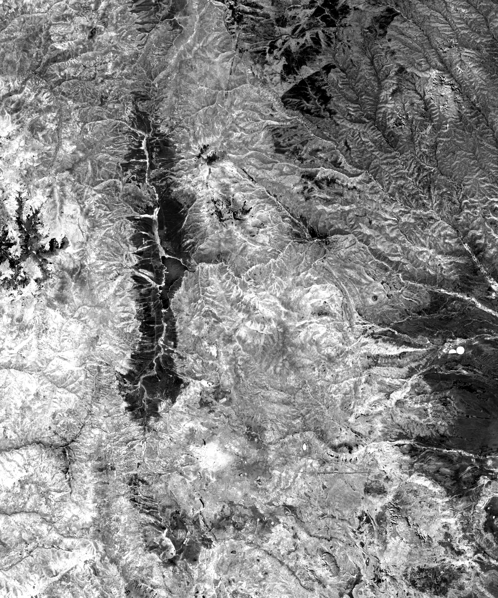

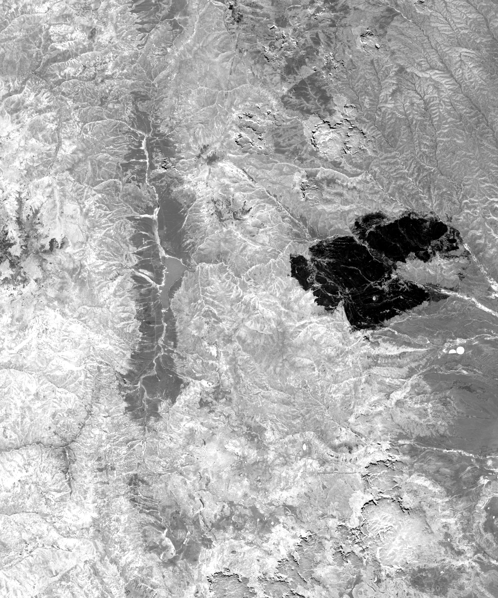

In [10]:
from IPython.display import display, Image

display(Image(
    os.path.join(workspace, 'processed_newmexico_before_red.png'),
    width=300,
    height=300
))
display(Image(
    os.path.join(workspace, 'processed_newmexico_after_red.png'), 
    width=300,
    height=300
))

Water bodies can show similar NBR difference, like we see it above with a river snaking in the south of the burned area. Therefore, it is necessary to mask them out.
We  also need to mask out clouds occurring in either input image. For this purpose, we will create a single combined water and cloud mask.

To detect  the  water bodies we will use the Normalized Difference Water Index (NDWI).

In [22]:
# Merge the two resulted products in one to process bandmath between their bands
sourceProducts= HashMap()
sourceProducts.put('master', processed_newmexico_before)
sourceProducts.put('slave', processed_newmexico_after)
parametersCollocate = HashMap()
parametersCollocate.put('masterComponentPattern', '${ORIGINAL_NAME}_May')
parametersCollocate.put('slaveComponentPattern', '${ORIGINAL_NAME}_June')
productCollocated = GPF.createProduct(
    'Collocate', parametersCollocate, sourceProducts
)

In [23]:
# NDWI & cloud mask processing
paramsCloudWater = HashMap()
targetBand = BandDescriptor()
targetBand.name = 'cloud_water_mask'
targetBand.type = 'float32'
targetBand.expression = ('if (CloudMask_May > 0 or CloudMask_June > 0 '
                         'or ((B3_May-B8_May)/(B3_May+B8_May)) >= 0.0) '
                         'then 1 else 0')
targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand
paramsCloudWater.put('targetBands', targetBands)
productCloudWater = GPF.createProduct(
    'BandMaths',
    paramsCloudWater,
    productCollocated
)

In [24]:
# Merge the new mask with main product
sourceProducts= HashMap()
sourceProducts.put('masterProduct', productCollocated)
sourceProducts.put('slaveProduct', productCloudWater)
parametersMerge = HashMap()
productWithNDWI = GPF.createProduct('Merge', parametersMerge, sourceProducts)
ProductIO.writeProduct(
    productWithNDWI,
    os.path.join(workspace, 'NDWI'),
    'Geotiff'
)

Finally, we apply the last bandmath, the Relativized Band Ratio (RBR) that takes the two products in input to compute the difference between the first and second date and maximize the burned area delimitation. To discriminate real burned areas from others lands we set a low-value limit at 0.27, corresponding to the minimum where we can affirm that it is a burned area.

In [25]:
def rbr_compute(product):
    targetBand1 = BandDescriptor()
    targetBand1.name = 'RBR'
    targetBand1.type = 'float32'
    targetBand1.expression = ('if cloud_water_mask == 0 '
                              'then ((NBR_May - NBR_June) / (NBR_May + 1.001)) '
                              'else NaN')
    targetBands1 = jpy.array(
        'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor',
        1
    )
    targetBands1[0] = targetBand1
    paramsRBR = HashMap()
    paramsRBR.put('targetBands', targetBands1)
    productRBR = GPF.createProduct('BandMaths', paramsRBR, product)
    targetBand2 = BandDescriptor()
    targetBand2.name = 'RBR_classified'
    targetBand2.type = 'float32'
    targetBand2.expression = ('if RBR > 0.27 '
                              'then RBR '
                              'else NaN')
    targetBands2 = jpy.array(
        'org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 
        1
    )
    targetBands2[0] = targetBand2
    paramsRBRFinal = HashMap()
    paramsRBRFinal.put('targetBands', targetBands2)
    productRBRFinal = GPF.createProduct(
        'BandMaths',
        paramsRBRFinal,
        productRBR
    )
    ProductIO.writeProduct(
        productRBRFinal,
        os.path.join(workspace, 'RBR_product_final'),
        'Geotiff'
    )

rbr_compute(productWithNDWI)

We have a final mask that only covers areas actually burned. It can be export as a KMZ to be viewed in Google Earth or any cartographic service. To visualize it on a map, we reduce image resolution and reproject it in mercator projection.

In [27]:
# Reproject the image in Mercator
subprocess.call([
    'rio',
    'warp',
    os.path.join(workspace, 'RBR_product_final.tif'),
    os.path.join(workspace, 'RBR_product_visu_3857.tif'),
    '--dst-crs="EPSG:3857"',
    '-resampling="bilinear"',
    '--overwrite'
])

2

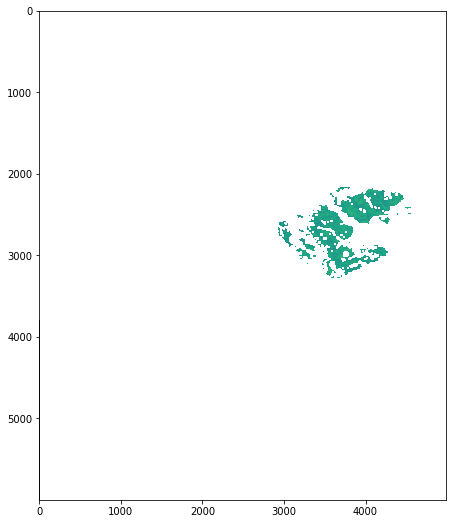

In [28]:
# Display the RBR
with rasterio.open(os.path.join(workspace, 'RBR_product_visu_3857.tif')) as rbr_product:
    burned_areas = rbr_product.read(1)
plt.figure(figsize=(9, 9))
im = plt.imshow(burned_areas)

## Final result

Now we display the mask on a base map like Open Street map:

In [31]:
from folium.raster_layers import ImageOverlay

final_mask = np.zeros((burned_areas.shape[0], burned_areas.shape[1], 4))
final_mask[:,:,3] = burned_areas
imageio.imwrite(os.path.join(workspace, 'burned_areas_snappy.png'), final_mask)

m = folium.Map([36.5, -105], zoom_start=9, tiles='openstreetmap')
ImageOverlay(
    image=os.path.join(workspace, 'burned_areas_snappy.png'),
    name='Mercator projection SW',
    bounds=[[36.2361722222, -105.448691667], [36.7767944444, -104.8907]],
    opacity=1,
).add_to(m)

folium.LayerControl().add_to(m)
m